[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/docs/tutorials/redshift_example.ipynb)
[![Open on Github](https://img.shields.io/badge/github-Open%20on%20Github-black?logo=github)](https://github.com/jfcrenshaw/pzflow/blob/main/docs/tutorials/redshift_example.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow corner

-------------------
## Customizing the bijector and latent space

This example notebook demonstrates how to chain multiple bijectors to make a custom bijector, and how to choose the latent space
We will build the default bijector that PZFlow automatically uses.
You don't need to do this, as PZFlow will automatically build this bijector for you, but it's good to see how it is done, plus it allows me to explain the design decisions a little bit.

See the following notebooks for genuine examples of when you might want to build a custom bijector.

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import corner

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ShiftBounds, RollingSplineCoupling
from pzflow.distributions import Uniform
from pzflow.examples import get_galaxy_data

For this example, we will use the example galaxy data included with PZFlow.

It's okay if you don't know what this data is - it's just a 7-dimensional space of galaxy data.

If you are familiar with galaxy data:
- the first column is the galaxy's true redshift
- the following 6 columns are the galaxy's true apparent magnitudes in the LSST photometric bands

Again, don't worry if you are unfamiliar with this kind of data - the astronomy details are unimportant for understanding this notebook.

In [3]:
data = get_galaxy_data()
data

,redshift,u,g,r,i,z,y
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056
...,...,...,...,...,...,...,...
99995,0.661883,25.665363,25.703183,25.362422,24.936967,24.771529,24.691300
99996,0.864290,28.342505,27.654294,26.638448,25.615190,25.108037,24.938998
99997,0.973176,27.781264,27.386962,26.760144,26.107564,25.584028,25.403601
99998,2.281685,29.324894,28.148004,27.312318,26.883849,26.416446,25.762161


We will build a Flow to model this data.

You must understand a little about how normalizing flows work. Normalizing flows start with input data that is from some complicated data distribution. They then apply a series of transformations (bijections) that transform the data distribution into a simple latent distribution.

All of the heavy lifting of transforming the data distribution into the latent distribution is handled by a `RollingSplineCoupling`. This bijection alternates [Neural Spline Couplings](https://arxiv.org/abs/1906.04032) and "Rolling" layers. `RollingSplineCoupling` takes several parameters, which you can see in the documentation/API, but the only required parameter is `nlayers`.

`nlayers` sets the number of `(Neural Spline, Roll)` couplets that are chained together inside of `RollingSplineCoupling`. We will set `nlayers = 7` to match the dimension of the input data.

The other *really important* parameter is the range of the splines, `B`. You don't have to provide `B` -- it's set to `B=5` by default. However, it is important to understand that the splines are only defined on the range [-B, B]. Any data outside of this range will not be transformed (it just has the identity applied).

If you look at the DataFrame above, you will see that lots of our data lies outside the range [-5, 5]!
It is our job to make sure that our data lies within that range *before* it is passed into the `RollingSplineCoupling`.

We can do this using the `ShiftBounds` bijector. `ShiftBounds` has 3 parameters:
- `mins` - the minima of the columns in your data
- `maxs` - the maxima of the columns in your data
- `B` - the range your data will be mapped onto: [-B, B].

In other words, if we had some data `x` that ran from 3 to 7, then `ShiftBounds(3, 7, 2)` would transform `x` so that its range ran from [-2, 2].

In our case, since we left `B=5` in the `RollingSplineCoupling`, we need to make sure that all of our data columns lay in the range [-5, 5]. *However*, `RollingSplineCoupling` performs better when the data isn't too close to the edge of its support (it will still work - you will just see some weird edge artifacts when sampling from the flow). To avoid edge effects, we will map all of our data columns into the range [-4, 4].

So our final bijection will be:
`ShiftBounds(mins, maxs, B=4) --> RollingSplineCoupling(7, B=5)`.
In PZFlow, you chain these together using the `Chain` bijector:

In [4]:
# get minima and maxima for each column
mins = jnp.array(data.min(axis=0))
maxs = jnp.array(data.max(axis=0))

# get the number of dimensions
ndim = data.shape[1]

# build the bijector
bijector = Chain(
    ShiftBounds(mins, maxs, B=4),
    RollingSplineCoupling(ndim, B=5),
)

Now we have our bijector!

We also need a latent space. By default, PZFlow uses a uniform distribution over the range [-5, 5].
This is because the `RollingSplineCoupling` has a default range [-5, 5], and we need our bijector to match this range.
You could choose any compact distribution that matches this range, but uniform is the simplest choice.

PZFlow uses this distribution by default, but just like the bijector, we will manually construct it just for demonstration:

In [5]:
latent = Uniform(input_dim=ndim, B=5)

We are finally ready to construct the normalizing flow!
Just like before, we must tell it the names of our data columns, but this time we will explicitly pass a bijector and a latent distribution

Note: the order of the column names you give to PZFlow MUST match the order of the columns implicit in the `mins` and `maxs` you gave to `ShiftBounds` above. This is the ONLY time you have to keep track of the column ordering. After creating the flow, PZFlow will always use the column names to access the correct data. 

In [6]:
flow = Flow(data.columns, bijector=bijector, latent=latent)

Now let's train the flow!

In [7]:
%%time 
losses = flow.train(data, epochs=200, verbose=True)

Training 200 epochs 
Loss:
(0) 20.4908
(1) 2.1882
(11) -3.0561
(21) -3.7004
(31) -3.5159
(41) -4.3430
(51) -4.7489
(61) -4.0210
(71) -5.0300
(81) -3.9104
(91) 0.3195
(101) -5.2164
(111) -5.3040
(121) -4.9196
(131) -6.1689
(141) -5.9213
(151) -6.3125
(161) -6.4114
(171) -6.6141
(181) -6.0520
(191) -6.2788
(200) -5.7158
CPU times: user 1h 15min 25s, sys: 5min 3s, total: 1h 20min 28s
Wall time: 18min 1s


Now let's plot the training losses to make sure everything looks like we expect it to...

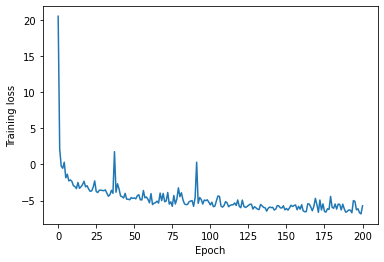

In [8]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Great! It looks like we could get better performance if we train for longer or use some kind of regularization, but this is sufficient for this demo.

Now we can draw samples from the flow, and compare these samples to the original data set.

In [9]:
samples = flow.sample(10000, seed=0)

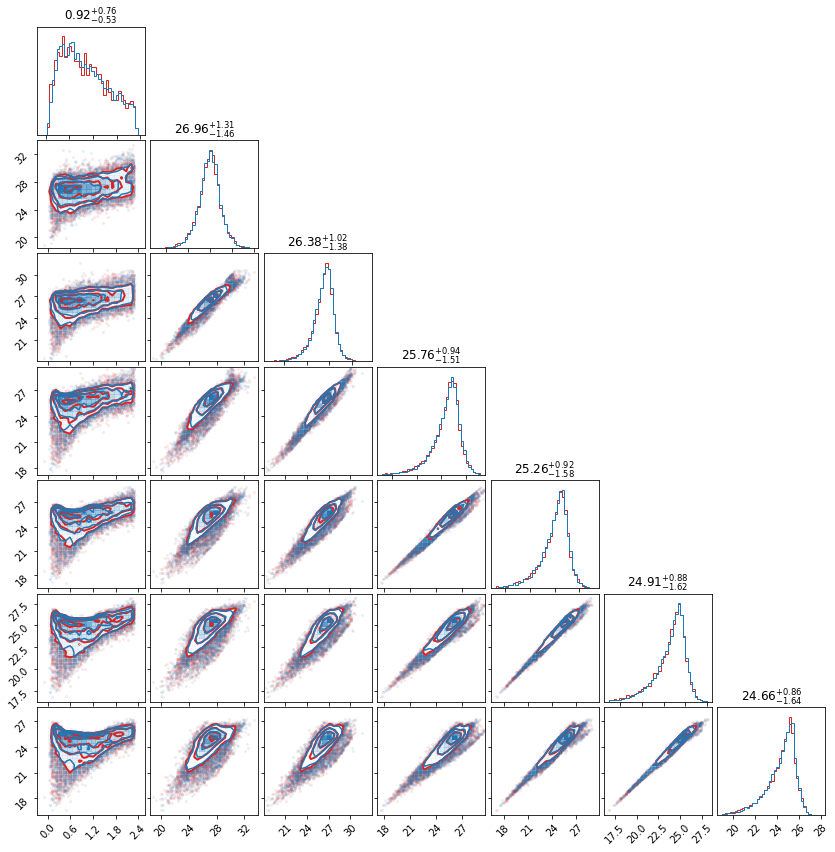

In [10]:
fig = plt.figure(figsize=(12,12))

ranges = [(-0.1,2.4), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True);

The original data is in blue, while the distribution learned by the normalizing flow is in red.

This looks great!

We can also use the flow to calculate redshift posteriors for galaxies:

In [11]:
grid = jnp.linspace(0, 2, 100)
pdfs = flow.posterior(samples, column="redshift", grid=grid)

Let's plot a few different posteriors (in blue), along with the true redshifts of the galaxies (in red):

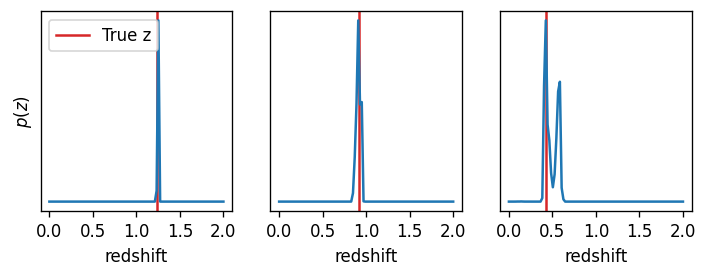

In [13]:
fig, axes = plt.subplots(1,3,figsize=(7,2.2), dpi=120)

idx = [0, 3, 12]
for i,ax in zip(idx, axes):
    true_z = samples['redshift'][i]
    ax.axvline(true_z, 0, 1, c="C3",
               label='True z')
    ax.plot(grid, pdfs[i])
    ax.set(xlabel="redshift",
           xticks=[0,0.5,1,1.5,2],
           yticks=[])
axes[0].legend()
axes[0].set(ylabel='$p(z)$')
plt.show()

We can also draw posteriors for magnitudes.
For example, lets draw posteriors for the $u$ band:

In [17]:
u_grid = jnp.arange(24, 32, 0.1)
u_pdfs = flow.posterior(samples, column='u', grid=u_grid)

Let's plot the $u$ band posteriors for the same galaxies above:

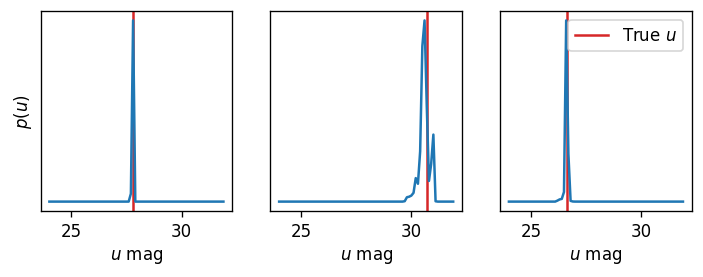

In [19]:
fig, axes = plt.subplots(1,3,figsize=(7,2.2), dpi=120)

idx = [0, 3, 12]
for i,ax in zip(idx, axes):
    true_u = samples['u'][i]
    ax.axvline(true_u, 0, 1, c="C3",
               label='True $u$')
    ax.plot(u_grid, u_pdfs[i])
    ax.set(xlabel="$u$ mag", 
           yticks=[])
axes[2].legend()
axes[0].set(ylabel='$p(u)$')
plt.show()

Now let's store some information with the flow about the data it was trained on.

In [21]:
flow.info = f"""
This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import get_galaxy_data
>>> data = get_galaxy_data()

This flow was created with pzflow version {pzflow.__version__}
"""

In [22]:
print(flow.info)


This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import get_galaxy_data
>>> data = get_galaxy_data()

This flow was created with pzflow version 3.0.0



This example flow is also packaged with PZFlow, so you can load it and play with it whenever you want:

In [25]:
from pzflow.examples import get_example_flow
flow = get_example_flow()

See! It's the same one:

In [26]:
print(flow.info)


This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import get_galaxy_data
>>> data = get_galaxy_data()

This flow was created with pzflow version 3.0.0

